In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00


In [ ]:
!yolo detect train model=yolo11n.pt data='/content/drive/MyDrive/contagem_fardos/data.yaml' epochs=150 imgsz=640 project='/content/drive/MyDrive/contagem_fardos/runs' name='treino4'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/contagem_fardos/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=Fa

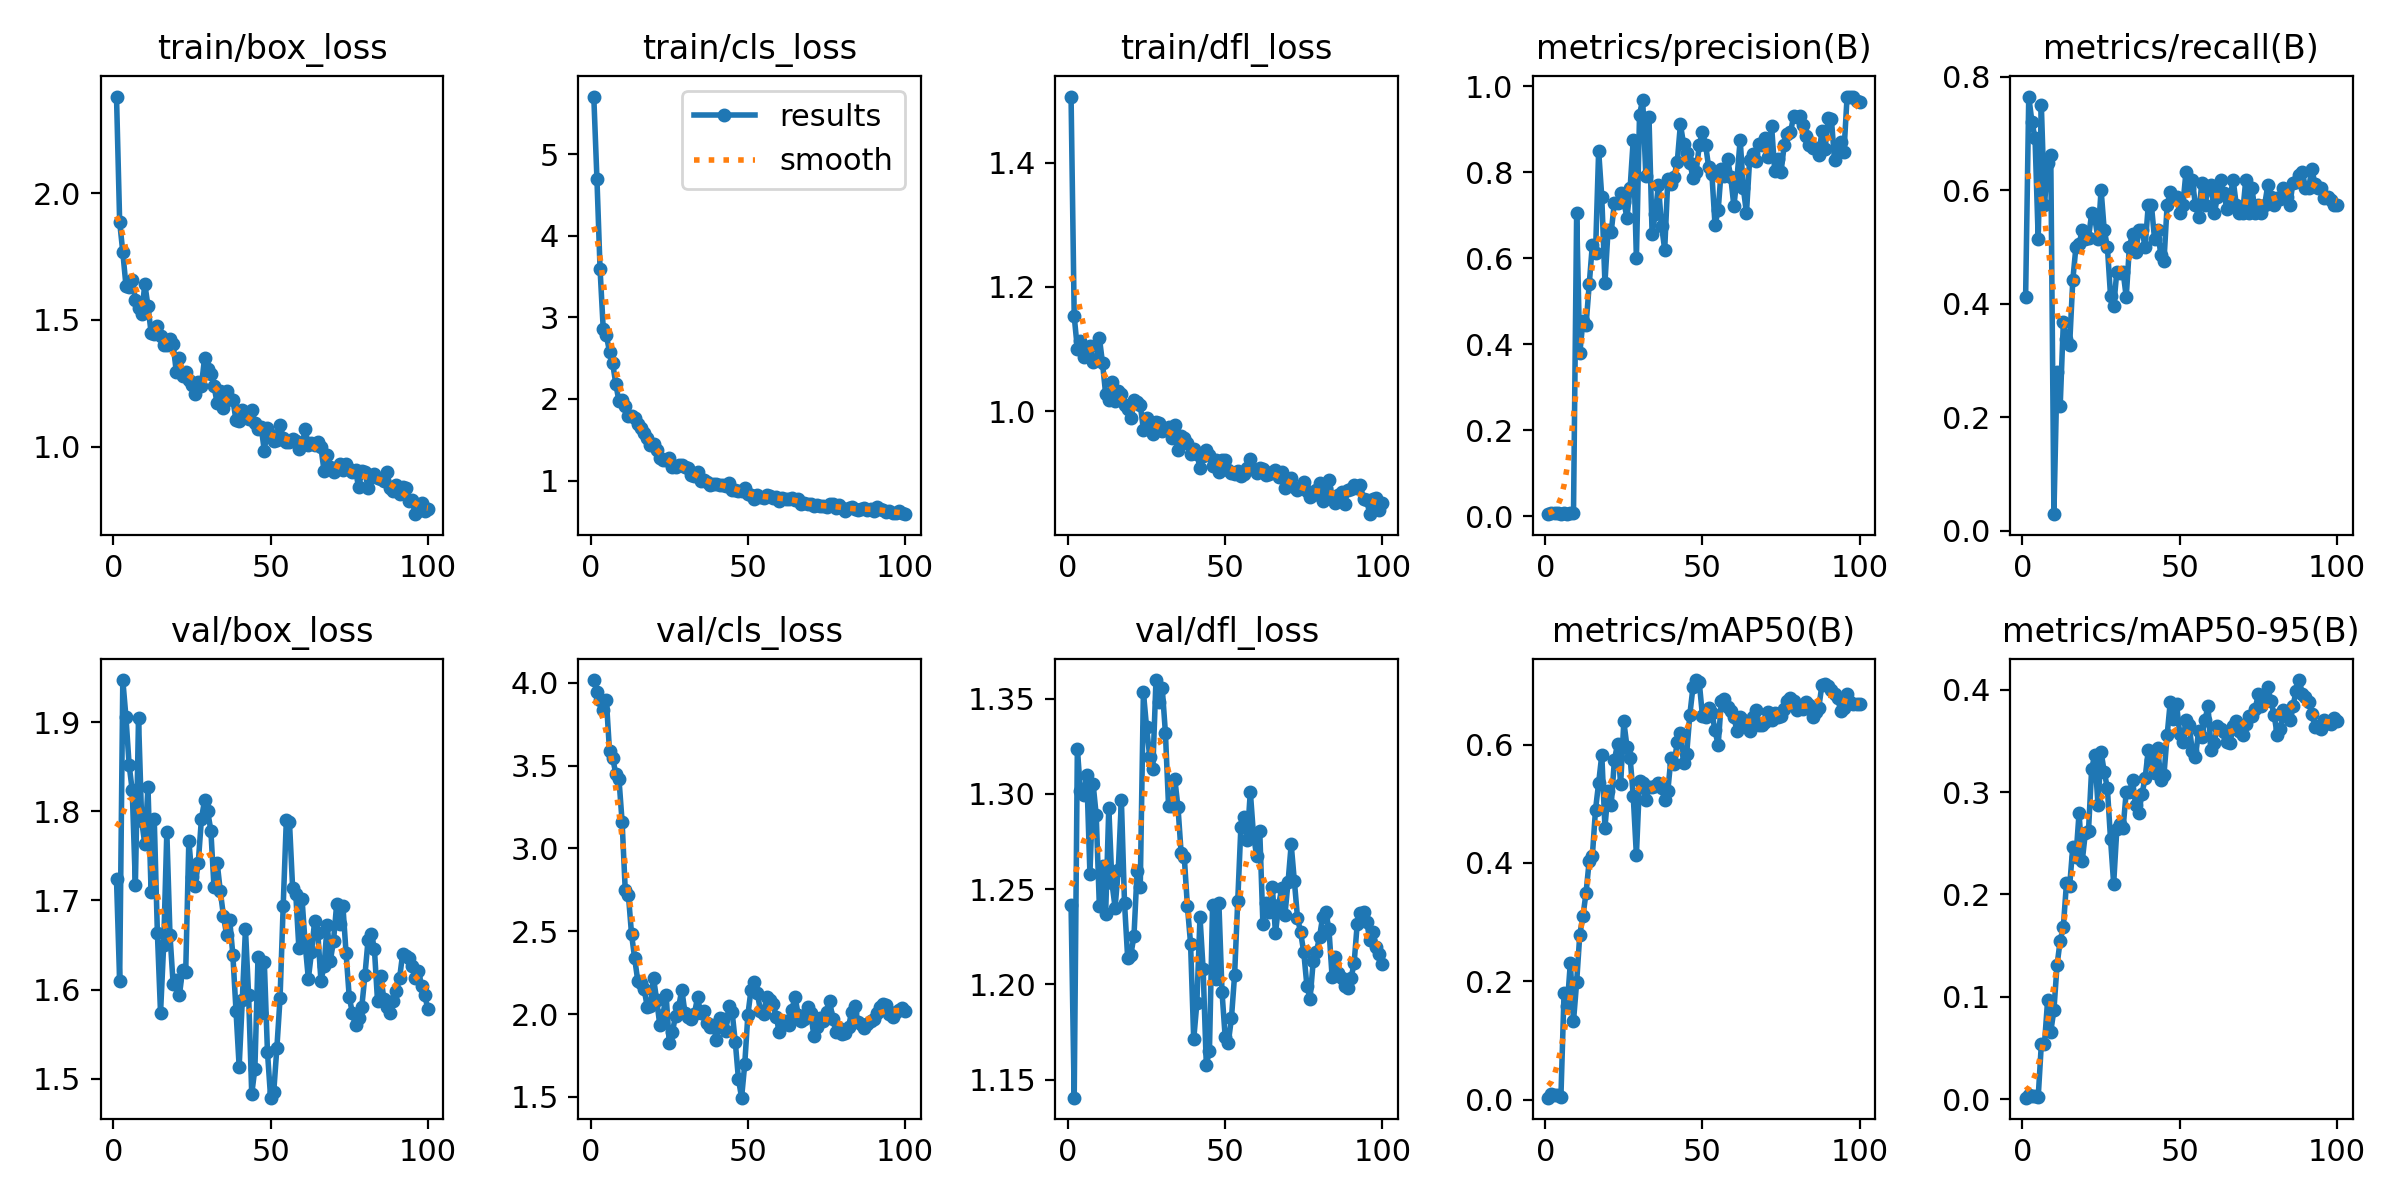

In [3]:
from IPython.display import Image

Image(filename='/content/drive/MyDrive/contagem_fardos/runs/treino3/results.png')

In [ ]:
!yolo dete# Caminhos
modelo = '/content/drive/MyDrive/contagem_fardos/runs/treino4/weights/best.pt'
video_entrada = '/content/drive/MyDrive/contagem_fardos/videos/video2.mp4'
saida = '/content/drive/MyDrive/contagem_fardos/runs/predict_video2'

# Cria pasta de saída no Drive (se não existir)
!mkdir -p {saida}

# Executa a detecção e salva direto no Drive
!yolo detect predict model={modelo} source={video_entrada} project={saida} name='saida' save=True


A saída de streaming foi truncada nas últimas 5000 linhas.
video 1/1 (frame 8645/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 8.0ms
video 1/1 (frame 8646/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 10.6ms
video 1/1 (frame 8647/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 8.6ms
video 1/1 (frame 8648/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 8.0ms
video 1/1 (frame 8649/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 7.8ms
video 1/1 (frame 8650/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 13.8ms
video 1/1 (frame 8651/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 8.2ms
video 1/1 (frame 8652/22301) /content/drive/MyDrive/contagem_fardos/videos/video2.mp4: 384x640 2 fardos, 8.7ms
video 1/1 (frame 8653/22301) /content/drive/MyDrive

Código para fazer a contagem dos fardos

In [6]:
# ===============================================
# 🚀 DETECÇÃO E CONTAGEM DE FARDOS - VERSÃO FINAL OTIMIZADA
# ===============================================

from ultralytics import YOLO
import cv2
import numpy as np
from IPython.display import clear_output
import time

# Caminhos
video_input = '/content/drive/MyDrive/contagem_fardos/videos/video2.mp4'
video_output = '/content/drive/MyDrive/contagem_fardos/videos/saida_contagem.mp4'
model_path = '/content/drive/MyDrive/contagem_fardos/runs/treino3/weights/best.pt'

# Carrega modelo YOLO
modelo = YOLO(model_path)

# Abre vídeo
cap = cv2.VideoCapture(video_input)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Processa em resolução menor para acelerar
proc_w, proc_h = 640, 360

# Salva vídeo de saída com resolução original
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_output, fourcc, fps, (width, height))

# Áreas de contagem normalizadas (x_center, y_center, w, h)
areas_norm = [
    (0.177083, 0.193056, 0.052083, 0.078704),
    (0.179948, 0.273148, 0.061979, 0.100000),
    (0.179948, 0.363889, 0.063021, 0.096296),
    (0.110677, 0.286111, 0.067187, 0.320370)
]

# Converte coordenadas normalizadas para pixels (base original)
def normal_to_pixel(xc, yc, w, h, frame_w, frame_h):
    x1 = int((xc - w / 2) * frame_w)
    y1 = int((yc - h / 2) * frame_h)
    x2 = int((xc + w / 2) * frame_w)
    y2 = int((yc + h / 2) * frame_h)
    return (x1, y1, x2, y2)

areas_pix = [normal_to_pixel(*a, width, height) for a in areas_norm]

# Controle de contagem
ids_contados = set()
contador = 0
frame_count = 0
start_time = time.time()

print("🔄 Iniciando processamento...")

# Loop principal
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Redimensiona para processamento mais rápido
    frame_small = cv2.resize(frame, (proc_w, proc_h))

    # Predição com rastreamento persistente
    resultados = modelo.track(source=frame_small, conf=0.5, persist=True, verbose=False)

    if resultados and resultados[0].boxes.id is not None:
        boxes = resultados[0].boxes.xyxy.cpu().numpy()
        ids = resultados[0].boxes.id.cpu().numpy()

        for box, obj_id in zip(boxes, ids):
            # Escala de volta para resolução original
            x1, y1, x2, y2 = box
            x1 = int(x1 * width / proc_w)
            y1 = int(y1 * height / proc_h)
            x2 = int(x2 * width / proc_w)
            y2 = int(y2 * height / proc_h)
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)

            # Desenha centro e bounding box
            cv2.circle(frame, (cx, cy), 3, (0, 255, 0), -1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Verifica se entrou na área de contagem
            for (ax1, ay1, ax2, ay2) in areas_pix:
                if ax1 <= cx <= ax2 and ay1 <= cy <= ay2:
                    if obj_id not in ids_contados:
                        ids_contados.add(obj_id)
                        contador += 1
                    break

    # Desenha áreas de contagem
    for (x1, y1, x2, y2) in areas_pix:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Exibe contador
    cv2.putText(frame, f'Fardos Contados: {contador}', (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3)

    # Atualiza progresso a cada 10 frames
    if frame_count % 10 == 0:
        clear_output(wait=True)
        progresso = (frame_count / total_frames) * 100
        tempo_decorrido = time.time() - start_time
        print(f"📹 Processando frame {frame_count}/{total_frames} — {progresso:.1f}% concluído")
        print(f"⏱️ Tempo decorrido: {tempo_decorrido:.1f}s — Total atual: {contador} fardos")

    # Grava frame no vídeo de saída
    out.write(frame)

# Finalização
cap.release()
out.release()
tempo_total = time.time() - start_time
clear_output(wait=True)

print("✅ Processamento concluído com sucesso!")
print(f"📦 Total de fardos contados: {contador}")
print(f"💾 Vídeo salvo em: {video_output}")
print(f"🕒 Tempo total: {tempo_total:.1f}s ({tempo_total/60:.1f} min)")

✅ Processamento concluído com sucesso!
📦 Total de fardos contados: 32
💾 Vídeo salvo em: /content/drive/MyDrive/contagem_fardos/videos/saida_contagem.mp4
🕒 Tempo total: 620.2s (10.3 min)
